In [17]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import scipy

#compare
p0 = 101325
T0 = 300 #paper
phi = 0.7
alpha = 0.6 #paper>0.6~0.8
width = 0.02 #2cm
loglevel = 0

xh2 = alpha / (1 - alpha) * 1
fuel = {'CH4': 1, 'H2': xh2}
oxidizer = {'O2': 1, 'N2': 3.76}

gas = ct.Solution('gri30.yaml')
gas.TP = T0, p0
gas.set_equivalence_ratio(phi, fuel, oxidizer)

In [18]:
flame = ct.FreeFlame(gas, width=width)
flame.solve(loglevel, auto=True)
flame_speed = flame.velocity[0]
print(f'Flame speed: {flame_speed:.5f} m/s')

Flame speed: 0.34056 m/s


In [19]:
flame_cf = ct.CounterflowPremixedFlame(gas=gas, width=width)
flame_cf.transport_model = 'multicomponent'
flame_cf.energy_enabled = True
flame_cf.set_refine_criteria(ratio=3, slope=0.1, curve=0.2, prune=0.02)

flame_cf.reactants.mdot = 1
flame_cf.products.mdot = 1
flame_cf.set_initial_guess(equilibrate=False)

#check-initial gas composition
print(gas)

flame_cf.solve(loglevel, auto=True)

In [20]:
#check minus sign (integral_numerator, mass_fraction_diff)
#unburnt->burnt

def calculate_consumption_speed(flame, gas, fuel_species):
    rho_u = flame.density[0]
    total_fuel_mass_fraction = sum(flame.Y[gas.species_index(fuel), 0] for fuel in fuel_species)

    integral_numerator = 0
    for fuel in fuel_species:
        i_fuel = gas.species_index(fuel)
        nk = flame.Y[i_fuel, 0] / total_fuel_mass_fraction
        integral = scipy.integrate.simpson(gas.molecular_weights[i_fuel] * flame.net_production_rates[i_fuel], x=flame.grid)
        integral_numerator += nk * integral

    mass_fraction_diff = sum(flame.Y[gas.species_index(fuel), -1] - flame.Y[gas.species_index(fuel), 0] for fuel in fuel_species)
    S_cF = integral_numerator / (rho_u * mass_fraction_diff)
    
    return S_cF

In [21]:
# set mass flow range, calculate ScF (example 10 values)
mdot_values = [10,20,30,40,50,60,70,80,90,100]
ScF_values = []

# change mdot values in for loop
for mdot in mdot_values:
    flame_cf.reactants.mdot = mdot  # update
    flame_cf.products.mdot = mdot
    flame_cf.solve(loglevel, auto=False)
    
    # 각 mdot에 대해 flame_speed 업데이트
    flame_speed = flame_cf.velocity[0]
    print(f'Flame speed: {flame_speed:.5f} m/s')
    
    ScF = calculate_consumption_speed(flame_cf, gas, ['CH4', 'H2'])
    ScF_values.append(ScF)

    grad_u = np.gradient(flame.velocity, flame.grid) 
    max_grad_idx = np.argmax(np.abs(grad_u))  # find max |du/dx| index
    max_grad_value = grad_u[max_grad_idx]  # value
    print(f"Index of max |du/dx|: {max_grad_idx}")

    # calculate thermal diffusivity
    cp = flame.cp_mass[0]
    density = flame.density_mass[0]
    lambda_ = flame.thermal_conductivity[0]
    thermal_diffusivity = lambda_ / (density * cp)
    print(f"Thermal diffusivity of reactants (α): {thermal_diffusivity:.5e} m^2/s")
    
    # calculate strain rate (Ka)
    Ka = thermal_diffusivity / flame_speed * max_grad_value
    print(f"Strain rate (Ka): {Ka:.5e} 1/s")
    
print(ScF_values)

Flame speed: 54.55718 m/s
Index of max |du/dx|: 9
Thermal diffusivity of reactants (α): 2.67433e-05 m^2/s
Strain rate (Ka): 1.48239e-03 1/s
Flame speed: 109.11436 m/s
Index of max |du/dx|: 9
Thermal diffusivity of reactants (α): 2.67433e-05 m^2/s
Strain rate (Ka): 7.41193e-04 1/s
Flame speed: 163.67155 m/s
Index of max |du/dx|: 9
Thermal diffusivity of reactants (α): 2.67433e-05 m^2/s
Strain rate (Ka): 4.94129e-04 1/s
Flame speed: 218.22873 m/s
Index of max |du/dx|: 9
Thermal diffusivity of reactants (α): 2.67433e-05 m^2/s
Strain rate (Ka): 3.70596e-04 1/s
Flame speed: 272.78591 m/s
Index of max |du/dx|: 9
Thermal diffusivity of reactants (α): 2.67433e-05 m^2/s
Strain rate (Ka): 2.96477e-04 1/s
Flame speed: 327.34310 m/s
Index of max |du/dx|: 9
Thermal diffusivity of reactants (α): 2.67433e-05 m^2/s
Strain rate (Ka): 2.47064e-04 1/s
Flame speed: 381.90028 m/s
Index of max |du/dx|: 9
Thermal diffusivity of reactants (α): 2.67433e-05 m^2/s
Strain rate (Ka): 2.11769e-04 1/s
Flame speed: 4

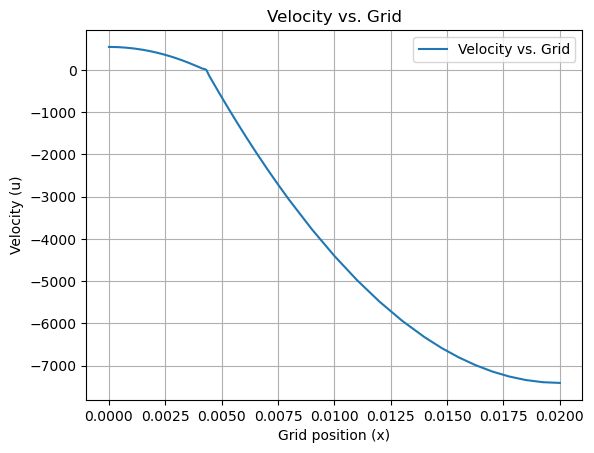

In [22]:
# plot grid-velocity graph
plt.plot(flame_cf.grid, flame_cf.velocity, label='Velocity vs. Grid')
plt.xlabel('Grid position (x)')
plt.ylabel('Velocity (u)')
plt.title('Velocity vs. Grid')
plt.legend()
plt.grid(True)
plt.show()

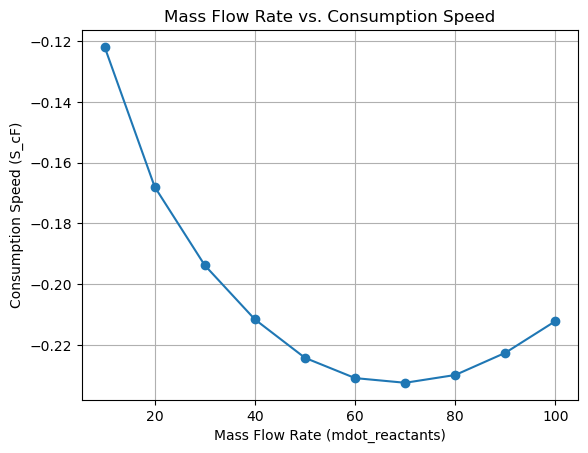

In [23]:
plt.plot(mdot_values, ScF_values, marker='o')
plt.xlabel('Mass Flow Rate (mdot_reactants)')
plt.ylabel('Consumption Speed (S_cF)')
plt.title('Mass Flow Rate vs. Consumption Speed')
plt.grid(True)
plt.show()